In [7]:
import boto3
import time
import json
import csv
import requests
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError

from src.data_reader import DataReader
from src.network import EdgeSplitter, PaperNLP, Network
from src.component import construct_component, write_component
from src.graphing import AuthorNetwork, GraphSpace
from src.source_selector import Recommender


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def author_lookup(_id, field='papers'):
    resp = requests.get(f'http://api.semanticscholar.org/v1/author/{_id}')
    try: 
        return resp.json()[field]
    except KeyError:
        return False

In [3]:
def author_lookup(_id):
    resp = requests.get(f'http://api.semanticscholar.org/v1/author/{_id}')
    return set(itm['paperId'] for itm in resp.json()['papers'])

In [4]:
client = MongoClient()
db = client['capstone']

In [9]:
a_network = AuthorNetwork(4100442, db.papers)

In [171]:
fields = ['paperAbstract','title','entities']
nlp = PaperNLP(*fields)
splitter = EdgeSplitter()
A0,At,E0,Et = splitter.split(X.paper_nodes, X.paper_edges)
nlp.fit(A0)
S0,St = [nlp.similarity_matrix(A) for A in (A0,At)]
y0,yt = E0['edge'], Et['edge']
for field in fields:
    E0[field + '_similarity'] = S0[field].lookup(col_labels=E0['src'], row_labels=E0['dst'])
    Et[field + '_similarity'] = St[field].lookup(col_labels=Et['src'], row_labels=Et['dst'])

In [173]:
E0['age'] = abs(A0['year'][E0['dst']].values - A0['year'][E0['src']].values)
Et['age'] = abs(At['year'][Et['dst']].values - At['year'][Et['src']].values)

E0['age'] = np.where(E0['age'].isnull(), 0, E0['age'])
Et['age'] = np.where(Et['age'].isnull(), 0, Et['age'])

/Users/alexklein/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9160187411469511


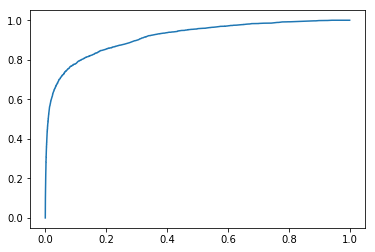

In [174]:
gbc = GradientBoostingClassifier()
gbc.fit(E0.drop(columns=['src','dst','edge'], axis=1), y0.astype(int).values.reshape(-1,1))
tpr, fpr, thr = roc_curve(y_score=gbc.predict_proba(
    Et.drop(columns=['src','dst','edge']))[:,1], 
                          y_true=yt.astype(int))
print(roc_auc_score(y_score=gbc.predict_proba(
    Et.drop(columns=['src','dst','edge']))[:,1],
      y_true=yt.astype(int)))
plt.plot(tpr,fpr)


In [115]:
X = AuthorNetwork(2262347, db.papers)
rec = Recommender(GradientBoostingClassifier(), 0.5, 5, 'paperAbstract','title','entities')
rec.fit(X.paper_nodes)

/Users/alexklein/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1]:
rec.predict(k=20, x=pd.DataFrame([{'_id':'test', 'paperAbstract':sample_abstract, 'title':sample_title, 'entities':[]}]))

NameError: name 'rec' is not defined

In [114]:
%pdb 
rec.predict(k=20, x=pd.DataFrame([{'_id':'test', 'paperAbstract':sample_abstract, 'title':sample_title, 'entities':[]}]))

Automatic pdb calling has been turned OFF


,_id,authors,doi,doiUrl,entities,inCitations,journalName,journalPages,journalVolume,outCitations,paperAbstract,pdfUrls,pmid,s2PdfUrl,s2Url,sources,title,venue,year
_id,,,,,,,,,,,,,,,,,,,
f827a2ca0d21ad63678e1f3931c044a7ee8775ae,f827a2ca0d21ad63678e1f3931c044a7ee8775ae,"[{'name': 'Jay M. Ling', 'ids': []}, {'name': ...",,,"[Blood Vessel Tissue, Business process, Decisi...","[7b371aa8f09cb16b270ec790b0d33c40e73c9be0, 49d...",,,,"[13e75ed0f374bbfe34211b8501b4d26d7fd8afca, 214...",An important element of successful engineering...,[http://www.srl.gatech.edu/publications/2006/c...,,http://pdfs.semanticscholar.org/f827/a2ca0d21a...,https://semanticscholar.org/paper/f827a2ca0d21...,[],Managing the Collection of Information under U...,,2006.0
cd909e0488c7751bb0ed609484fb15ce8fc703a2,cd909e0488c7751bb0ed609484fb15ce8fc703a2,"[{'name': 'Hans-Georg Stork', 'ids': ['3152113...",,,"[AS-Interface, Ability, Adaptive system, Algor...",[],,,,"[02a698470f476de722e78b20d0ddd92d3781bbfc, 561...",We briefly sketch some of the many concepts an...,[http://www.cikon.de/Text_EN/CogNotes1.pdf],,http://pdfs.semanticscholar.org/cd90/9e0488c77...,https://semanticscholar.org/paper/cd909e0488c7...,[],Cognition and ( Artificial ) Cognitive Systems...,,2004.0
392a3aa22324a5574bc732506477697ec7ced206,392a3aa22324a5574bc732506477697ec7ced206,"[{'name': 'D Teichmann', 'ids': ['2463163']}, ...",10.1088/0967-3334/34/9/963,https://doi.org/10.1088/0967-3334/34/9/963,"[Biological Neural Networks, Decision Trees, M...","[8f81cdaf210600f3f71df1ce005367a52100cd83, c89...",Physiological measurement,963-75,34 9,"[1c2c1e3cffbdfa08d76edf578d71ad06a8d31848, 7dc...",A system for classification of motion patterns...,[],23945071v1,,https://semanticscholar.org/paper/392a3aa22324...,[Medline],Human motion classification based on a textile...,Physiological measurement,2013.0
3644c3e246b64b7fe3129b67792054439579e41a,3644c3e246b64b7fe3129b67792054439579e41a,"[{'name': 'Paul Havig', 'ids': ['30720282']}, ...",,,"[Ability, Algorithm, Anatomic Node, Artificial...",[],,,,"[02a698470f476de722e78b20d0ddd92d3781bbfc, bfd...",Current command and control (C2) terminology i...,[http://www.dodccrp.org/events/12th_ICCRTS/Pap...,,http://pdfs.semanticscholar.org/3644/c3e246b64...,https://semanticscholar.org/paper/3644c3e246b6...,[],Putting the Science Back in C2: What Do the Bu...,,2007.0
11d1eb407108e85c4a932849e9a4c2d237285bbe,11d1eb407108e85c4a932849e9a4c2d237285bbe,"[{'name': 'Christiaan J. J. Paredis', 'ids': [...",,,"[Clarify, Decision, Decision Making, Decision ...",[d710880dede0500037241e2fd9567b46aef408fb],,,,"[3f2de1526250c060b3f2201c3bef0b259746e2ca, ef5...",An important element of successful engineering...,[http://srl2.gatech.edu/btw/files/IMECE2006-14...,,http://pdfs.semanticscholar.org/11d1/eb407108e...,https://semanticscholar.org/paper/11d1eb407108...,[],An Information Economic Approach for Model Sel...,,2006.0
6aa4600114b079da9c3f3ee640bd0dd55c6d4dce,6aa4600114b079da9c3f3ee640bd0dd55c6d4dce,"[{'name': 'David Hardcastle', 'ids': ['2645349...",,,"[Artificial intelligence, Natural language gen...","[db3d1bf445626856d53b61310dd8f784d7723b76, c75...",,,,"[402200052fe06aa43e54d40a73168bf7c9619bac, a87...",Evaluating the output of NLG systems is notori...,[http://users.sussex.ac.uk/~drs22/publications...,,http://pdfs.semanticscholar.org/9267/9946a6c7e...,https://semanticscholar.org/paper/6aa4600114b0...,[DBLP],Can we Evaluate the Quality of Generated Text?,LREC,2008.0
75df680914c4abdb677e020aed709b7cf8dd3d10,75df680914c4abdb677e020aed709b7cf8dd3d10,"[{'name': 'Sergio Decherchi', 'ids': ['2674856...",,,"[Algorithm, Basis function, Cluster analysis, ...","[d4e5f3c52f6571c353172c6e31b91aaf8fdb0397, 0ae...",,,,[],Text-mining methods have become a key feature ...,[https://www.researchgate.net/profile/Sergio_D...,,http://pdfs.semanticscholar.org/75df/680914c4a...,https://semanticscholar.org/paper/75df680914c4...,[],A Text Clustering Framework for Information Re...,,1983.0
11a1dd480057b17b5f74f2

In [99]:
# %pdb
# pred = 
rec.predict(k=20, x=pd.DataFrame([{'_id':'test', 'paperAbstract':sample_abstract, 'title':sample_title, 'entities':[]}]))

,_id,authors,doi,doiUrl,entities,inCitations,journalName,journalPages,journalVolume,outCitations,paperAbstract,pdfUrls,pmid,s2PdfUrl,s2Url,sources,title,venue,year
_id,,,,,,,,,,,,,,,,,,,
f827a2ca0d21ad63678e1f3931c044a7ee8775ae,f827a2ca0d21ad63678e1f3931c044a7ee8775ae,"[{'name': 'Jay M. Ling', 'ids': []}, {'name': ...",,,"[Blood Vessel Tissue, Business process, Decisi...","[7b371aa8f09cb16b270ec790b0d33c40e73c9be0, 49d...",,,,"[13e75ed0f374bbfe34211b8501b4d26d7fd8afca, 214...",An important element of successful engineering...,[http://www.srl.gatech.edu/publications/2006/c...,,http://pdfs.semanticscholar.org/f827/a2ca0d21a...,https://semanticscholar.org/paper/f827a2ca0d21...,[],Managing the Collection of Information under U...,,2006.0
cd909e0488c7751bb0ed609484fb15ce8fc703a2,cd909e0488c7751bb0ed609484fb15ce8fc703a2,"[{'name': 'Hans-Georg Stork', 'ids': ['3152113...",,,"[AS-Interface, Ability, Adaptive system, Algor...",[],,,,"[02a698470f476de722e78b20d0ddd92d3781bbfc, 561...",We briefly sketch some of the many concepts an...,[http://www.cikon.de/Text_EN/CogNotes1.pdf],,http://pdfs.semanticscholar.org/cd90/9e0488c77...,https://semanticscholar.org/paper/cd909e0488c7...,[],Cognition and ( Artificial ) Cognitive Systems...,,2004.0
392a3aa22324a5574bc732506477697ec7ced206,392a3aa22324a5574bc732506477697ec7ced206,"[{'name': 'D Teichmann', 'ids': ['2463163']}, ...",10.1088/0967-3334/34/9/963,https://doi.org/10.1088/0967-3334/34/9/963,"[Biological Neural Networks, Decision Trees, M...","[8f81cdaf210600f3f71df1ce005367a52100cd83, c89...",Physiological measurement,963-75,34 9,"[1c2c1e3cffbdfa08d76edf578d71ad06a8d31848, 7dc...",A system for classification of motion patterns...,[],23945071v1,,https://semanticscholar.org/paper/392a3aa22324...,[Medline],Human motion classification based on a textile...,Physiological measurement,2013.0
3644c3e246b64b7fe3129b67792054439579e41a,3644c3e246b64b7fe3129b67792054439579e41a,"[{'name': 'Paul Havig', 'ids': ['30720282']}, ...",,,"[Ability, Algorithm, Anatomic Node, Artificial...",[],,,,"[02a698470f476de722e78b20d0ddd92d3781bbfc, bfd...",Current command and control (C2) terminology i...,[http://www.dodccrp.org/events/12th_ICCRTS/Pap...,,http://pdfs.semanticscholar.org/3644/c3e246b64...,https://semanticscholar.org/paper/3644c3e246b6...,[],Putting the Science Back in C2: What Do the Bu...,,2007.0
11d1eb407108e85c4a932849e9a4c2d237285bbe,11d1eb407108e85c4a932849e9a4c2d237285bbe,"[{'name': 'Christiaan J. J. Paredis', 'ids': [...",,,"[Clarify, Decision, Decision Making, Decision ...",[d710880dede0500037241e2fd9567b46aef408fb],,,,"[3f2de1526250c060b3f2201c3bef0b259746e2ca, ef5...",An important element of successful engineering...,[http://srl2.gatech.edu/btw/files/IMECE2006-14...,,http://pdfs.semanticscholar.org/11d1/eb407108e...,https://semanticscholar.org/paper/11d1eb407108...,[],An Information Economic Approach for Model Sel...,,2006.0
6aa4600114b079da9c3f3ee640bd0dd55c6d4dce,6aa4600114b079da9c3f3ee640bd0dd55c6d4dce,"[{'name': 'David Hardcastle', 'ids': ['2645349...",,,"[Artificial intelligence, Natural language gen...","[db3d1bf445626856d53b61310dd8f784d7723b76, c75...",,,,"[402200052fe06aa43e54d40a73168bf7c9619bac, a87...",Evaluating the output of NLG systems is notori...,[http://users.sussex.ac.uk/~drs22/publications...,,http://pdfs.semanticscholar.org/9267/9946a6c7e...,https://semanticscholar.org/paper/6aa4600114b0...,[DBLP],Can we Evaluate the Quality of Generated Text?,LREC,2008.0
75df680914c4abdb677e020aed709b7cf8dd3d10,75df680914c4abdb677e020aed709b7cf8dd3d10,"[{'name': 'Sergio Decherchi', 'ids': ['2674856...",,,"[Algorithm, Basis function, Cluster analysis, ...","[d4e5f3c52f6571c353172c6e31b91aaf8fdb0397, 0ae...",,,,[],Text-mining methods have become a key feature ...,[https://www.researchgate.net/profile/Sergio_D...,,http://pdfs.semanticscholar.org/75df/680914c4a...,https://semanticscholar.org/paper/75df680914c4...,[],A Text Clustering Framework for Information Re...,,1983.0
11a1dd480057b17b5f74f2

In [98]:
X.paper_nodes[X.paper_nodes['_id'] == '02bceddd42e9995f57bb5a5adb53114838e2bb27']['paperAbstract'].values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [97]:
# sample_abstract = '''In this paper we address the problem of classifying cited work into important and non-important to the developments presented in a research publication. This task is vital for the algorithmic techniques that detect and follow emerging research topics and to qualitatively measure the impact of publications in increasingly growing scholarly big data. We consider cited work as important to a publication if that work is used or extended in some way. If a reference is cited as background work or for the purpose of comparing results, the cited work is considered to be non-important. By employing five classification techniques (Support Vector Machine, Naïve Bayes, Decision Tree, K-Nearest Neighbors and Random Forest) on an annotated dataset of 465 citations, we explore the effectiveness of eight previously published features and six novel features (including context based, cue words based and textual based). Within this set, our new features are among the best performing. Using the Random Forest classifier we achieve an overall classification accuracy of 0.91 AUC'''


# '''BACKGROUND
# The primary determinant of reproductive age in women is the number of ovarian non-growing (primordial, intermediate and primary) follicles (NGFs). To better characterize the decline in NGF number associated with aging, we have employed modern stereology techniques to determine NGF number in women from birth to menopause.


# METHODS
# Normal human ovaries were collected from 122 women (aged 0-51 years) undergoing elective oophorectomy, organ donation or autopsy. After gross pathologic examination, systematic random sampling was utilized to obtain tissue for analysis by the fractionator/optical disector method. Models to describe the resulting decay curve were constructed and evaluated.


# RESULTS
# NGF decay was best described by a simple power function: log (y) = ax(b) + c, where a, b and c are constants and y = NGF count at age x (R(2) = 0.84, Sums of Squares Error = 28.18 on 119 degrees of freedom). This model implies that follicles decay faster with increasing age.


# CONCLUSIONS
# Unlike previous models of ovarian follicle depletion, our model predicts no sudden change in decay rate, but rather a constantly increasing rate. The model not only agrees well with observed ages of menopause in women, but also is more biologically plausible than previous models. Although the model represents a significant improvement compared with earlier attempts, a considerable percentage of the variation in NGF number between women cannot be explained by age alone.'''

sample_title = '''Identifying Important Citations Using Contextual Information from Full Text'''
#'''A new model of reproductive aging: the decline in ovarian non-growing follicle number from birth to menopause.'''



In [16]:
splitter = EdgeSplitter()
splitter.transform(A0)

,src,dst,edge
0,00000d6607966f4e7cdbbcff320bd34c37116c72,30c117108a9684436539014ad33ac8e15fb6dc91,1
1,00001129a7d3768e48570199c29352b586cb2e49,14199130a67364b64f461b60017c79ec67987024,1
2,000020df76aef798d28b35c4c7558409cfb63fcd,391c936f5c274f29c172e6fa9d8a42e7b98d7d6d,1
3,00002661ccea4507c4e89389449338960dc833e3,30c117108a9684436539014ad33ac8e15fb6dc91,1
4,0000280d857c23e884690ae6e0d22e094959e0b6,b88e5263c224be3acee38e18ff6d8a47310c2606,1
5,000071c6d35d677feb6a737941cc1a369838c28f,398483c0f72d1766f871ca97d5fae789a8998229,1
6,000078efd11373511cd9ff616e70ee1a0baf750d,e2daf007d295036fc4928d450f055df637e5868f,1
7,00008b0a226aa42b6c1148a8c4f4e0d976dc516a,0da51490d856493af4107e2c03fd227a55c09591,1
8,0000973aec306d2f93a4798bf1946f230280bb3e,641842a845c9a210dd7260609963f0013b3e79c7,1
9,0000a22b889d7726e21fdcb2d1449a413063072d,289532df41bddd14e26e493cd25e68e28478281c,1


/Users/alexklein/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9157339313123937


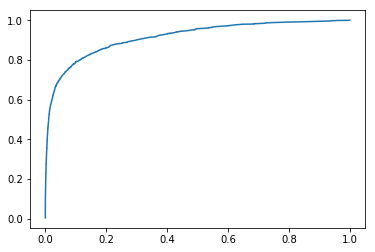

0.9157339272287149


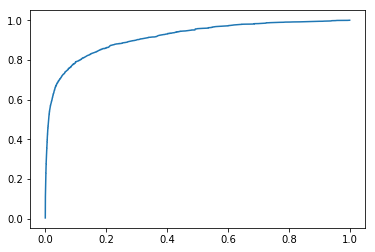

In [ ]:
gbc.feature_importances_

In [ ]:
def create_edges(X, in_='inCitations', out_='outCitations', directed=False):
    edge_list = []
    for dst, srcs in X[in_].iteritems():
        for src in srcs: 
            if not directed:
                edge_list.append(sorted((src, str(dst))))
            else:
                edge_list.append((src, dst))
    if out_ is not None:
        for src, dsts in X[out_].iteritems():
            for dst in dsts: edge_list.append((src, dst))
    edges = pd.DataFrame(edge_list, columns=['src', 'dst'])
    edges['id'] = edges.index
    return edges

def expand_feature(seq):
    out = []
    for itm in seq:
        out += itm
    return out

def repeat_itms(seq, n):
    if isinstance(seq, pd.Series):
        return expand_feature(n * seq.apply(lambda x: [x]))
    return list(map(lambda x,y: [x] * y, seq, n))

def repeat_rows(X, n):
    df = pd.DataFrame()
    for col in X.columns:
        df[col] = repeat_itms(X[col], n)
    return df

def create_authors(X, **kwargs):
    authors = pd.DataFrame(expand_feature(X['authors']))
    authors['papers'] = expand_feature(repeat_itms(X.index, X['authors'].apply(len)))
    authors['papers'] = authors['papers'].apply(lambda x: [x])
    X = repeat_rows(X, X['authors'].apply(len))
    
    authors['id'] = authors['ids'].apply(lambda x: x[0] if x else -1).astype(int)
    authors['missing_id'] = authors['ids'] == -1
    authors['coAuthors'] = (
        X['authors']
        .apply(lambda x: [itm['ids'] for itm in x])
        .apply(expand_feature)
    )
    for field in kwargs:
        authors[field] = X[field]
    kwargs['name'] = 'first'
    kwargs['coAuthors'] = 'sum'
    kwargs['papers'] = 'sum'
    kwargs['missing_id']= 'first'
    authors = authors.groupby('id').agg(kwargs)
    return authors.reset_index()

In [ ]:
def pd_to_gexf(edges, nodes, path, node_attr={}, edge_attr={}, dynamic=True, node_label=None):
    """
    Export two pandas frames to a single .gexf file for use in Gephi.
    ============
    Takes:
        edges: DataFrame object containing edges to export
        nodes: DataFrame object containing nodes to export
        path: string-location to save file
        attributes: keyword parameters corresponding to attribute names
    ============
    Returns: None
    """
    _nodes, _edges = '', ''
    _node_attr, _edge_attr = '', ''
    for i, (attribute, type_) in enumerate(node_attr.items()):
        _node_attr += f'      <attribute id="{i}" title="{attribute}" type="{type_}"/>\n'
    for i, (attribute, type_) in enumerate(edge_attr.items()):
        _edge_attr += f'      <attribute id="{i}" title="{attribute}" type="{type_}"/>\n'
    for _, n in nodes.iterrows():
        _nodes += f'      <node id="{n["id"]}" label="{n[node_label] if node_label else ""}" start="{n["year"]}" end="2018">\n'
        _nodes += f'        <attvalues>\n'
        for i, attr in enumerate(node_attr):
            _nodes += f'          <attvalue for="{i}" value="{n[attr]}"/>\n'
        _nodes += f'        </attvalues>\n'
        _nodes += '      </node>\n'
    for _, e in edges.iterrows():
        _edges += f'      <edge id="{e["id"]}" source="{e["src"]}" target="{e["dst"]}" start="{e["year"] if "year" in e else "2018"}" end="2018" weight="{e["weight"] if "weight" in e else "1"}">\n'
        _edges += f'        <attvalues>\n'
        for i, attr in enumerate(edge_attr):
            _edges += f'          <attvalue for="{i}" value="{e[attr]}"/>\n'
        _edges += f'        </attvalues>\n'
        _edges += '      </edge>\n'
    
    string =f"""<?xml version="1.0" encoding="UTF-8"?>
    <gexf xmlns="http://www.gexf.net/1.2draft" version="1.2" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.w3.org/2001/XMLSchema-instance">
      <graph mode="{'static' if not dynamic else 'dynamic'}" defaultedgetype="directed" name="">
        <attributes class="node">
  {_node_attr}
        </attributes>        
        <nodes>
  {_nodes}
        </nodes>
        <attributes class="edge">
  {_edge_attr}
        </attributes>     
        <edges>
  {_edges}
        </edges>
      </graph>
    </gexf>"""
    with open(path, 'w') as f:
        f.write(string)

In [ ]:
X = pd.read_json('data/component', lines=-1)
X.index = X['_id']
X.drop('_id', axis=1, inplace=True)
A = create_authors(X, year='min', paperAbstract='sum')
A['numPapers'] = A['papers'].apply(len)

In [ ]:
A_edges = create_edges(A, in_='coAuthors', out_=None, directed=False)
X_edges = create_edges(X, directed=True)
A_edges['weight'] = 1
A_edges = A_edges.groupby(['src','dst']).agg(
            {'id':'first',
             'weight': 'sum'}).reset_index()

In [ ]:
fields = ['paperAbstract']
nlp = PaperNLP(*fields)
splitter = EdgeSplitter()
A0,At,E0,Et = splitter.split(A, A_edges)
nlp.fit(A0)
S0,St = [nlp.similarity_matrix(A) for A in (A0,At)]
y0,yt = E0['edge'], Et['edge']
for field in fields:
    E0[field + '_similarity'] = S0[field].lookup(col_labels=E0['src'], row_labels=E0['dst'])
    Et[field + '_similarity'] = St[field].lookup(col_labels=Et['src'], row_labels=Et['dst'])

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(E0.loc[:, 'paperAbstract_similarity'].values.reshape(-1,1), y0.astype(int).values.reshape(-1,1))

In [ ]:
A_edges['src'] = A_edges['src'].astype(int)
A_edges['dst'] = A_edges['dst'].astype(int)
splitter.split_edges(A, A_edges)

In [ ]:
for src, dst in A_edges.iloc[:, :2].values:
    if dst in node_set: #and dst in node_set:
        print(src,dst)
        break

In [ ]:
client = MongoClient()
db = client['capstone']
# result = db.papers.find({'authors': {'name': 'N A Klein', 'ids': ['4100442']}})
# lst = []
# for paper in result:
#     lst.append(paper)